In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor


#### Load fit results

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]
fitting_type2 = 'gabor_solo_ridge_12ori_8sf_permutation_test'
out_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type2, n_from_end=0, \
                                  verbose=False)  for ss in subjects]

# create ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

#### Process results of permutation test, compute p-values

In [3]:
from utils import stats_utils
from plotting import summary_plots

p_voxels_orig = [[] for si in range(n_subjects)]

for si in range(n_subjects):

    # stats for single voxels
    r2_real_orig = out[si]['val_r2']
    r2_shuff_orig = out_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p_orig = np.mean(r2_real_orig[:,0,None]<=r2_shuff_orig[:,0,:], axis=1)
    _,pvals_fdr_orig = stats_utils.fdr_keepshape(p_orig, alpha=0.01, \
                                                   method='poscorr')
    p_voxels_orig[si] = pvals_fdr_orig
    
# thresholding voxels based on the permutation test
p = np.concatenate(p_voxels_orig, axis=0)
abv_thresh = p<0.01


#### Get info about the Gabor feature space

In [4]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


In [5]:
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)

#### Load image stats analysis

In [6]:
feature_type='gabor_solo'
subject=998
which_prf_grid=5;

path_to_load = default_paths.gabor_texture_feat_path
path_to_load = os.path.join(path_to_load, 'feature_stats')

fn1 = os.path.join(path_to_load, 'S%d_%s_mean_grid%d.npy'%(subject, feature_type, which_prf_grid))
fn2 = os.path.join(path_to_load, 'S%d_%s_var_grid%d.npy'%(subject, feature_type, which_prf_grid))

mean = np.load(fn1,allow_pickle=True)
var = np.load(fn2,allow_pickle=True)

fn1 = os.path.join(path_to_load, 'S%d_%s_categ_partial_corrs_grid%d.npy'%(subject, feature_type, which_prf_grid))
fn2 = os.path.join(path_to_load, 'S%d_%s_categ_nsamp_partial_corrs_grid%d.npy'%(subject, feature_type, which_prf_grid))

partial_corr = np.load(fn1,allow_pickle=True)
partial_nsamp = np.load(fn2,allow_pickle=True)
assert not np.any(partial_nsamp==0)
assert not np.any(np.isnan(partial_nsamp))

fn2load = os.path.join(default_paths.stim_labels_root, 'Highlevel_counts_all.npy')
counts = np.load(fn2load, allow_pickle=True).item()
axis_names = counts['categ_names']
axes_use = [0,1,2,3, 4,5,6,7]
axis_names = np.array(axis_names)[axes_use]
signed_names = axis_names
axis_names, signed_names

(array(['face', 'building', 'animate', 'inanimate', 'small', 'large',
        'indoor', 'outdoor'], dtype='<U9'),
 array(['face', 'building', 'animate', 'inanimate', 'small', 'large',
        'indoor', 'outdoor'], dtype='<U9'))

#### Correlate each voxel's sensitivity profile with the diagnostic feature channels for each semantic axis

In [8]:
n_vox = feature_corr.shape[0]
n_dims = len(signed_names)
tuning_dim_corrs = np.zeros((n_vox,n_dims))
tuning_var_corrs = np.zeros((n_vox,))
tuning_mean_corrs = np.zeros((n_vox,))

mean_vals = np.mean(mean, axis=1)
var_vals = np.mean(var, axis=1)
    
sem_vals = np.mean(partial_corr, axis=1)

assert not(np.any(np.isnan(sem_vals)))

# for vv in [0]:
for vv in range(n_vox):
    
    if np.mod(vv,5000)==0:
        print('%d/%d'%(vv, n_vox))
        
    # selectivity of the current voxel for each channel
    # vox_vals = allcorr_reshaped[vv,:,:].ravel()
    vox_vals = feature_corr[vv,:]
    
    tuning_mean_corrs[vv] = np.corrcoef(mean_vals, vox_vals)[0,1]
    tuning_var_corrs[vv] = np.corrcoef(var_vals, vox_vals)[0,1]
    
    for dim in range(n_dims):
        
        # raw correlation
        tuning_dim_corrs[vv,dim] = np.corrcoef(sem_vals[:,dim], vox_vals)[0,1]

0/150842
5000/150842
10000/150842
15000/150842
20000/150842
25000/150842
30000/150842
35000/150842
40000/150842
45000/150842
50000/150842
55000/150842
60000/150842
65000/150842
70000/150842
75000/150842
80000/150842
85000/150842
90000/150842
95000/150842
100000/150842
105000/150842
110000/150842
115000/150842
120000/150842
125000/150842
130000/150842
135000/150842
140000/150842
145000/150842
150000/150842


In [13]:
sem_vals = np.mean(partial_corr, axis=1)
sem_vals.shape

(96, 8)

In [14]:
colors = np.concatenate([np.flipud(cm.Purples(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Reds(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,5)))[1:3,:]])

colors_categ = np.concatenate([np.flipud(cm.Purples(np.linspace(0,1,6)))[2:3,:], \
                        np.flipud(cm.Reds(np.linspace(0,1,6)))[2:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,6)))[2:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,6)))[2:3,:]])

#### Average over ROIs

In [15]:
roi_tuning_mean_corrs = np.zeros((n_subjects, n_rois))
roi_tuning_var_corrs = np.zeros((n_subjects, n_rois))
roi_tuning_dim_corrs = np.zeros((n_subjects, n_rois, n_dims))

for si in range(n_subjects):
    
    for ri in range(n_rois):
        
        inds_this_roi = roi_def.get_indices(ri) & abv_thresh & (subject_inds==si)
     
        roi_tuning_mean_corrs[si,ri] = np.mean(tuning_mean_corrs[inds_this_roi], axis=0)
        roi_tuning_var_corrs[si,ri] = np.mean(tuning_var_corrs[inds_this_roi], axis=0)
        roi_tuning_dim_corrs[si,ri,:] = np.mean(tuning_dim_corrs[inds_this_roi,:], axis=0)


#### Plot the average partial correlation coefficient for each axis
Average over voxels in each ROI, then over subjects

-0.6539553606248609 0.8486438130908397
-0.7693181053142276 0.8571634777525772
-0.7461157778163274 0.6285535998418317
-0.7577879362038075 0.6343672282876703


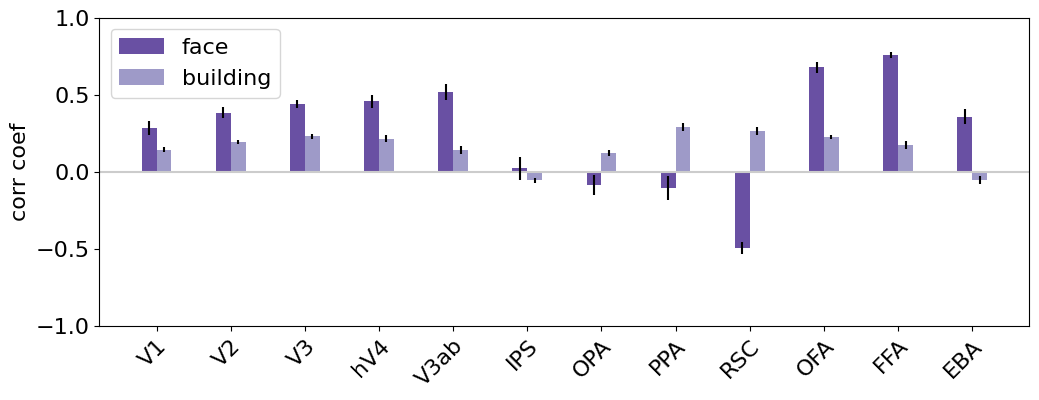

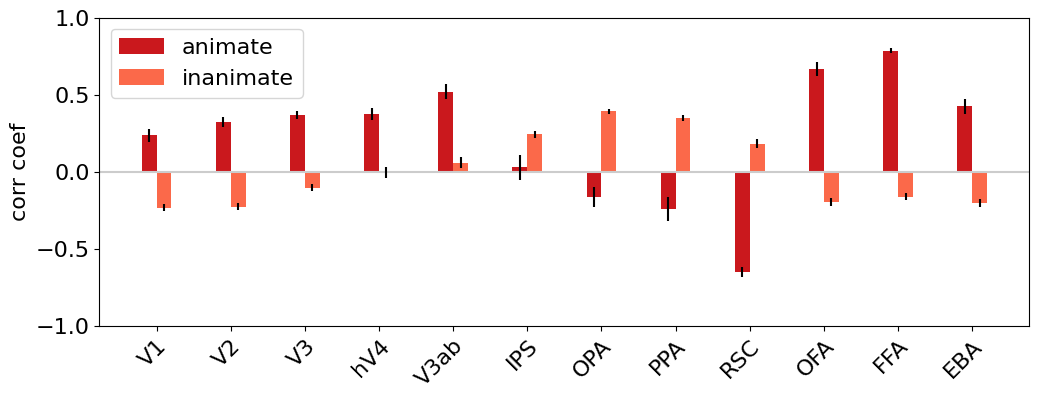

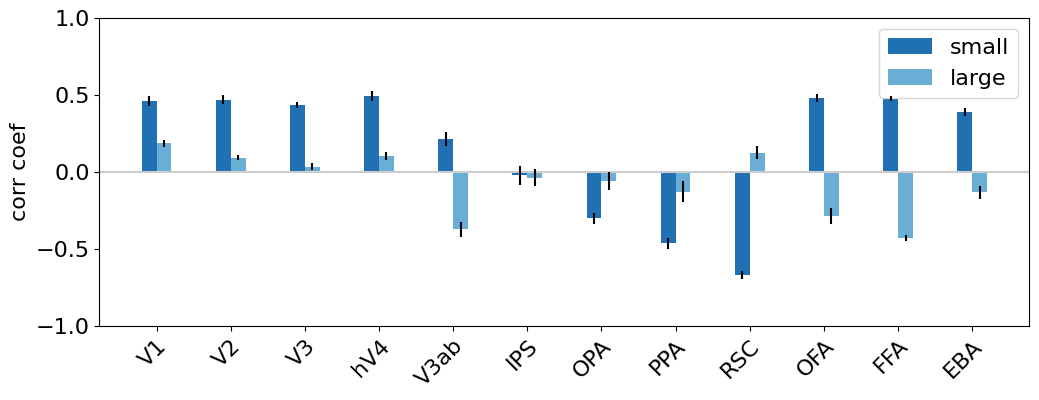

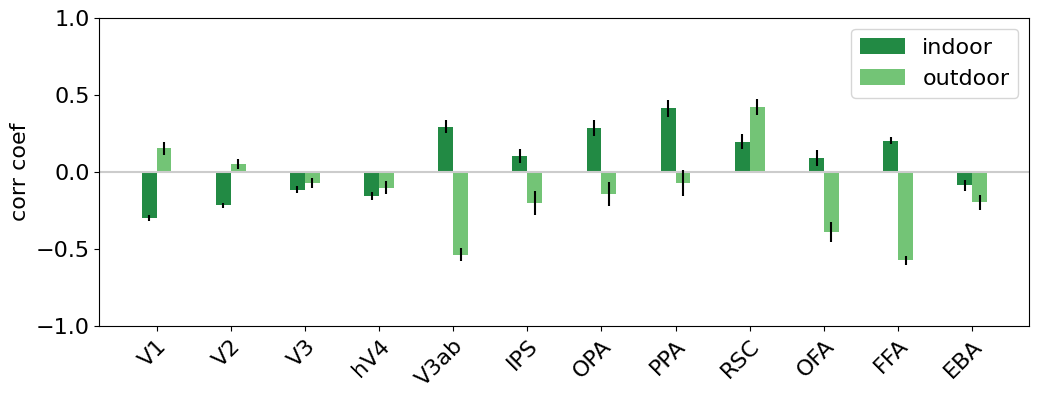

In [ ]:
roi_mean_vals = np.moveaxis(roi_tuning_dim_corrs, [0],[2])

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for axes_plot in [[0,1],[2,3],[4,5],[6,7]]:
 
    bw = 0.2;
    space = (1 - (bw*len(axes_plot)))/2
                  
    point_data = np.moveaxis(roi_mean_vals[:,axes_plot,:], [0,1,2], [1,2,0])
    print(np.min(point_data), np.max(point_data))
    fh = plot_utils.plot_multi_bars(mean_data=mean_vals[:,axes_plot], err_data=sem_vals[:,axes_plot], \
                                    # point_data = point_data, \
                                    colors=colors[axes_plot,:], space=space, \
                xticklabels=roi_names, ylabel='corr coef', \
                ylim=[-1, 1], horizontal_line_pos=0,\
                legend_labels=np.array(axis_names)[axes_plot], \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(12,4))

    # fn2save = os.path.join(default_paths.fig_path, \
    #                        'categ_selectivity_%s-%s.pdf'%(categ_names[axes_plot[0]], \
    #                                                       categ_names[axes_plot[1]]))
    # print(fn2save)
    # plt.savefig(fn2save)

-0.48040457718513063 0.5977419787990117


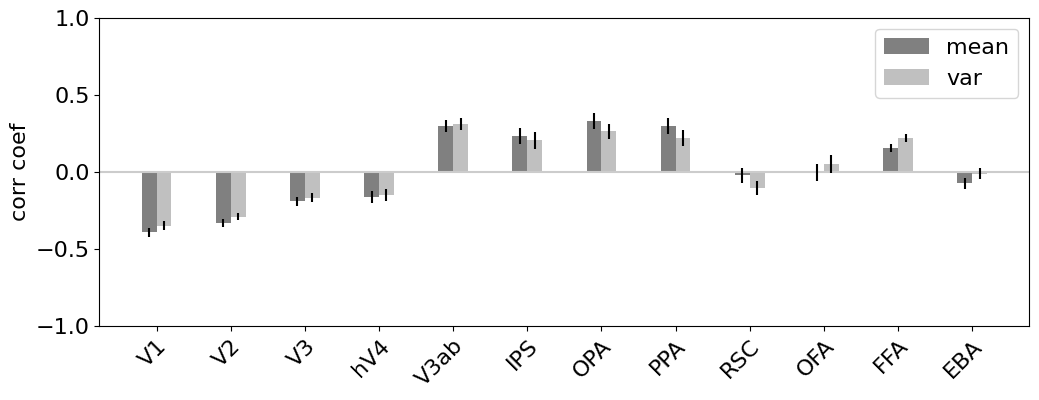

In [29]:
roi_mean_vals = np.concatenate([ roi_tuning_mean_corrs[:,:,None], \
                                roi_tuning_var_corrs[:,:,None]], axis=2)
roi_mean_vals = np.moveaxis(roi_mean_vals, [0],[2])

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

meanvar_colors = cm.gray(np.linspace(0,1,5))[2:4,:]

for axes_plot in [[0,1]]:
 
    bw = 0.2;
    space = (1 - (bw*len(axes_plot)))/2
                  
    point_data = np.moveaxis(roi_mean_vals[:,axes_plot,:], [0,1,2], [1,2,0])
    print(np.min(point_data), np.max(point_data))
    fh = plot_utils.plot_multi_bars(mean_data=mean_vals[:,axes_plot], err_data=sem_vals[:,axes_plot], \
                                    # point_data = point_data, \
                                    colors=meanvar_colors, space=space, \
                xticklabels=roi_names, ylabel='corr coef', \
                ylim=[-1, 1], horizontal_line_pos=0,\
                legend_labels=['mean','var'], \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(12,4))

    # fn2save = os.path.join(default_paths.fig_path, \
    #                        'categ_selectivity_%s-%s.pdf'%(categ_names[axes_plot[0]], \
    #                                                       categ_names[axes_plot[1]]))
    # print(fn2save)
    # plt.savefig(fn2save)